# Example: Cross-contour transport

This notebook uses the `cosima_cookbook` to calculate transport across an arbitrary contour. We do this by first creating the contour, such as sea surface height, and extracting the coordinates using `matplotlib`'s `Path` class. We then create some masks to indicate which direction is across the contour at each position along the contour. We then load the transport data and compute the transport, resulting in data with dimensions depth and along contour index. 

Computation times shown used conda environment `analysis3-22.07` on the large compute size on NCI's ARE.

First, we load useful packages:

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38377,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:34679,Total threads: 6
Dashboard: /proxy/42751/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:46357,


#### Choose database

In [3]:
session = cc.database.create_session()

#### Choose experiment

In [4]:
experiment = 'panant-0025-zstar-ACCESSyr2'

In [6]:
if experiment == 'panant-0025-zstar-ACCESSyr2':
    resolution = experiment[7:11].replace('-', '')
else:
    resolution = experiment[7:10].replace('-', '')
resolution

'0025'

#### Choose depth of contour

In [83]:
contour_depth = 650

#### Choose a latitude range so the contour fits in the range, but there is not too much extra space. Extra space slows down the computation.

In [84]:
if contour_depth <= 2500:
    lat_range = slice(-79, -55)
else:
    lat_range = slice(-79, -50)
# -55 for isobaths <= 2500
# -50 for isobaths >= 3000 m

#### We must make sure that this latitude range is so that the t-cells are always south and west of the u-cells.

This is important because the meridional and zonal transports occur on different grids to each other. We can check this by loading the `u`-cell and `t`-cell coordinates. 

We choose this convention so that later on when we create `numpy` grids of where the contour is and in what direction the contour goes.

In [85]:
%%time

yh = cc.querying.getvar(experiment, 'yh', session, ncfile='19910101.ocean_static.nc')
yh = yh.sel(yh=lat_range)
if contour_depth <= 2500:
    if resolution == '01':
        yh = yh[:-1]
else:
    yh = yh[:-1]

if resolution == '0025':
    yh = yh[:-1]

xh = cc.querying.getvar(experiment, 'xh', session, ncfile='19910101.ocean_static.nc')

yq = cc.querying.getvar(experiment, 'yq', session, ncfile='19910101.ocean_static.nc')
yq = yq.sel(yq=lat_range)
if (resolution == '005') or (resolution == '0025'):
    yq = yq[1:]
    

xq = cc.querying.getvar(experiment, 'xq', session, ncfile='19910101.ocean_static.nc')
xq = xq[1:]

CPU times: user 519 ms, sys: 70.6 ms, total: 590 ms
Wall time: 4.64 s


In [86]:
assert len(yh) == len(yq), 'help! y different size'

assert yh.min('yh')< yq.min('yq'), 'help! y wrong order (yh should be > yq)'

assert len(xh) == len(xq), 'help! x different size'

assert xh.min('xh')< xq.min('xq'), 'help! x wrong order (xh should be > xq)'

#### Load quantity we want a contour of, e.g. SSH averaged over a year

In [87]:
deptho = cc.querying.getvar(
    experiment, 'deptho', session, ncfile='19910101.ocean_static.nc')

# select latitude range
deptho = deptho.sel(yh=slice(yh[0], yh[-1]))

#### Choose your desired contour value

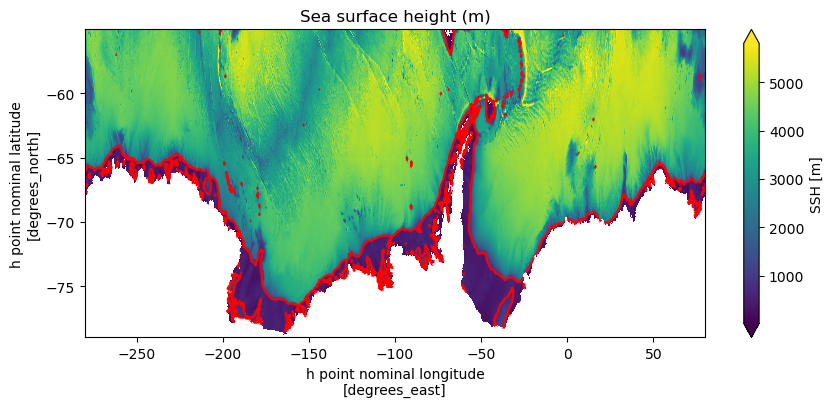

In [88]:
fig = plt.figure(figsize = (10, 4))

deptho.plot(extend='both', cbar_kwargs={'label': "SSH [m]"})
deptho.plot.contour(levels = [contour_depth], colors = 'r', linestyles = '-')
plt.title('Sea surface height (m)');

In [89]:
h = deptho.compute()

# Fill in land with zeros:
h = h.fillna(0)

In [90]:
# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

In [91]:
if grid_sel == 'u':
    x_var = xq
    y_var = yq
elif grid_sel == 't':
    x_var = xh
    y_var = yh

#### Select the contour 
If there are multiple contours satisfying this contour level, change the `count` in the `if` statement below until desired contour is highlighted red. Counting starts from the south west. For example, if we chose `count == 1` the Antarctic Peninsula would instead be selected, rather than the circumpolar contour.

650m: if count == 5: for 005deg
      
      if count == 4: for 01deg

1000m: if count == 1:

1500m: if count == 1:

2000m: if count == 1:

2500m: if count == 1:

3000m: if count == 1:

3500m: for 005 deg:
        
        if count == 1: 
        
        if (count == 55) or (count == 71):

       for 01deg
        
        if count == 1: 
        
        if (count == 32) or (count == 41) or (count == 44):
       
4000m: for 005 deg
        if (count == 3)
        
        if (count == 48) or (count == 57) or (count == 65):
        
      for 01deg
      
       if (count == 7)
    
       if (count == 35) or (count == 45) or (count == 51):
      

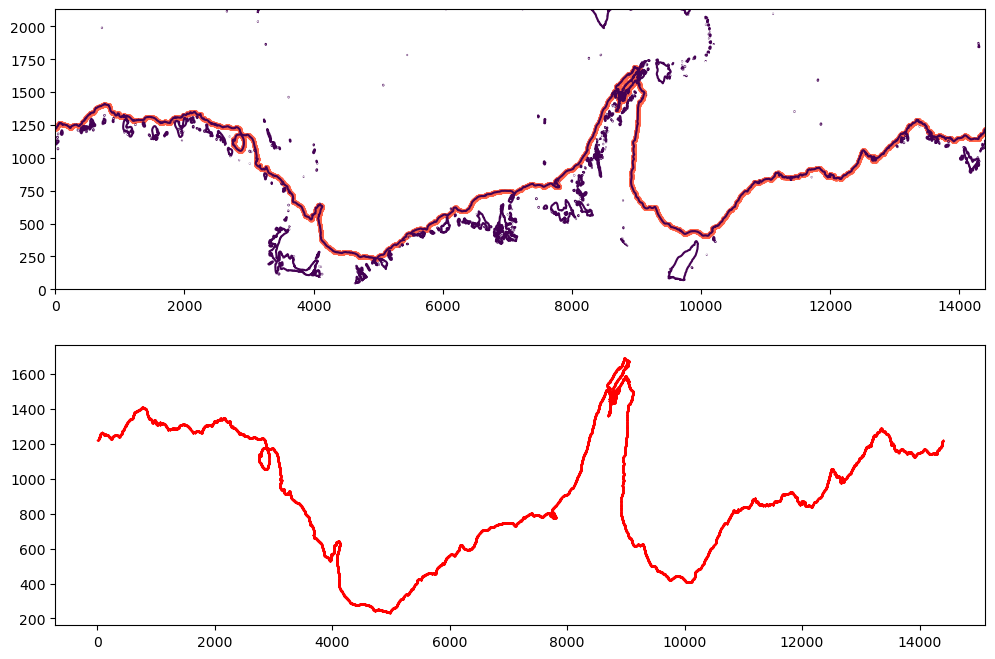

In [94]:
if contour_depth == 650:
    fig = plt.figure(figsize = (12, 8))
    plt.subplot(2, 1, 1)
    count = 0
    x_contour = []
    y_contour = []

    if resolution == '01':
        count_temp = 4
    else:
        count_temp = 5

    # Create the contour:
    sc = plt.contour(h, levels=[contour_depth])
    for collection in sc.collections:
        for path in collection.get_paths():
            count += 1
            if count == count_temp:
                # Write down the lat/lon indices
                for ii in range(np.size(path.vertices[:,0])):
                    x_contour.append(int(np.round(path.vertices[ii][0])))
                    y_contour.append(int(np.round(path.vertices[ii][1])))

    plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato')

    plt.subplot(2, 1, 2)
    plt.plot(x_contour, y_contour, '.', color='r', markersize=.5);

In [95]:
if (contour_depth > 650) and (contour_depth <= 3000):
    fig = plt.figure(figsize = (12, 8))
    plt.subplot(2, 1, 1)
    count = 0
    x_contour = []
    y_contour = []

    # Create the contour:
    sc = plt.contour(h, levels=[contour_depth])
    for collection in sc.collections:
        for path in collection.get_paths():
            count += 1
            if count == 1:
                # Write down the lat/lon indices
                for ii in range(np.size(path.vertices[:,0])):
                    x_contour.append(int(np.round(path.vertices[ii][0])))
                    y_contour.append(int(np.round(path.vertices[ii][1])))

    plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato')

    plt.subplot(2, 1, 2)
    plt.plot(x_contour, y_contour, '.', color='r', markersize=.5);

In [96]:
if contour_depth == 3500:
    fig = plt.figure(figsize = (12, 8))
    plt.subplot(2, 1, 1)
    count = 0
    x_contour = []
    y_contour = []

    if resolution == '01':
        count_temp1 = 32
        count_temp2 = 41
        count_temp3 = 44
    elif resolution == '005':
        count_temp1 = 55
        count_temp2 = 71
        count_temp3 = 71

    # Create the contour:
    sc = plt.contour(h, levels=[contour_depth])
    for collection in sc.collections:
        for path in collection.get_paths():
            count += 1
            if count == 1:
                # Write down the lat/lon indices
                for ii in range(np.size(path.vertices[:,0])):
                    if ii == 0:
                        x_contour_first = int(np.round(path.vertices[ii][0]))
                        y_contour_first = int(np.round(path.vertices[ii][1]))
                        if x_contour_first != 0:
                            for jj in range(0, x_contour_first):
                                x_contour.append(jj)
                                y_contour.append(y_contour_first)
                    x_contour.append(int(np.round(path.vertices[ii][0])))
                    y_contour.append(int(np.round(path.vertices[ii][1])))
                x_contour_last = x_contour[-1]
                y_contour_last = y_contour[-1]

            if (count == count_temp1) or (count == count_temp2) or (count == count_temp3):
                # Write down the lat/lon indices
                for ii in range(np.size(path.vertices[:,0])):
                    if ii == 0:
                        # extend isobath to western boundary
                        x_contour_first = int(np.round(path.vertices[ii][0]))
                        y_contour_first = int(np.round(path.vertices[ii][1]))
                        assert y_contour_last == y_contour_first, 'contour is not connected at same latitude'
                        for jj in range(x_contour_last, x_contour_first):
                            x_contour.append(jj)
                            y_contour.append(y_contour_last)
                    x_contour.append(int(np.round(path.vertices[ii][0])))
                    y_contour.append(int(np.round(path.vertices[ii][1])))
                # cut off isobath turning back to the ridge NW of the peninsula
                if count == 55:
                    x_contour = x_contour[:-700]
                    y_contour = y_contour[:-700]
                    for jj in range(y_contour[-1], len(h.yh)):
                        x_contour.append(x_contour[-1])
                        y_contour.append(jj)
                x_contour_last = x_contour[-1]
                y_contour_last = y_contour[-1]
    # extend isobath to eastern boundary
    if x_contour_last != (len(h.xh)-1):
        for jj in range(x_contour_last, len(h.xh)):
            x_contour.append(jj)
            y_contour.append(y_contour_last)
        

    plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato')

    plt.subplot(2, 1, 2)
    plt.plot(x_contour, y_contour, '.', color='r', markersize=.5);

In [97]:
if contour_depth == 4000:
    fig = plt.figure(figsize = (12, 8))
    plt.subplot(2, 1, 1)
    count = 0
    x_contour = []
    y_contour = []

    if resolution == '01':
        count_temp = 7
        count_temp1 = 35
        count_temp2 = 45
        count_temp3 = 51
    elif resolution == '005':
        count_temp = 3
        count_temp1 = 42
        count_temp2 = 52
        count_temp3 = 60

    # Create the contour:
    sc = plt.contour(h, levels=[contour_depth])
    for collection in sc.collections:
        for path in collection.get_paths():
            count += 1
            if count == count_temp:
                # Write down the lat/lon indices
                for ii in range(np.size(path.vertices[:,0])):
                    if ii == 0:
                        x_contour_first = int(np.round(path.vertices[ii][0]))
                        y_contour_first = int(np.round(path.vertices[ii][1]))
                        if x_contour_first != 0:
                            for jj in range(0, x_contour_first):
                                x_contour.append(jj)
                                y_contour.append(y_contour_first)
                    x_contour.append(int(np.round(path.vertices[ii][0])))
                    y_contour.append(int(np.round(path.vertices[ii][1])))
                x_contour_last = x_contour[-1]
                y_contour_last = y_contour[-1]

            if (count == count_temp1) or (count == count_temp2) or (count == count_temp3):
                # Write down the lat/lon indices
                for ii in range(np.size(path.vertices[:,0])):
                    if ii == 0:
                        # extend isobath to western boundary
                        x_contour_first = int(np.round(path.vertices[ii][0]))
                        y_contour_first = int(np.round(path.vertices[ii][1]))
                        assert y_contour_last == y_contour_first, 'contour is not connected at same latitude'
                        for jj in range(x_contour_last, x_contour_first):
                            x_contour.append(jj)
                            y_contour.append(y_contour_last)
                    x_contour.append(int(np.round(path.vertices[ii][0])))
                    y_contour.append(int(np.round(path.vertices[ii][1])))
                x_contour_last = x_contour[-1]
                y_contour_last = y_contour[-1]
    # extend isobath to eastern boundary
    if x_contour_last != (len(h.xh)-1):
        for jj in range(x_contour_last, len(h.xh)):
            x_contour.append(jj)
            y_contour.append(y_contour_last)
        

    plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato')

    plt.subplot(2, 1, 2)
    plt.plot(x_contour, y_contour, '.', color='r', markersize=.5);

#### Processing
Now process these coordinates to make sure there are no double ups.

In [99]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [100]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [101]:
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

Due to the discrete grid, the values on our contour are not exactly the same. We check this makes sense -- if this plot is blank, then something has gone wrong.

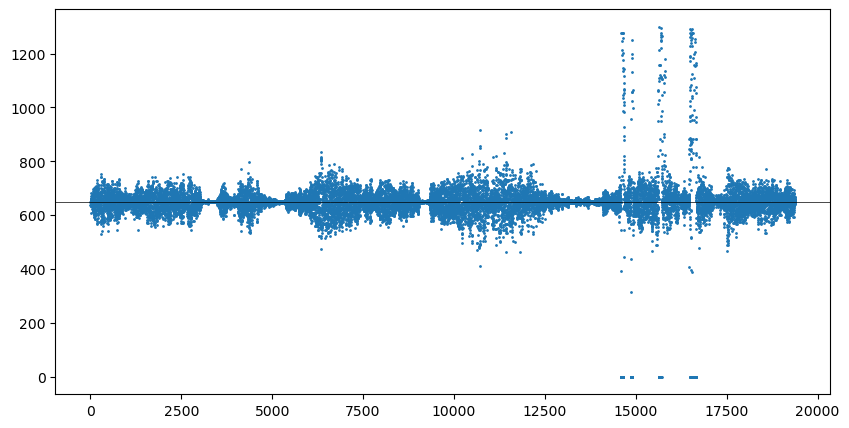

In [102]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

#### Get lat and lon along the contour

In [103]:
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[x_contour[ii]]
    lat_along_contour[ii] = y_var[y_contour[ii]]

#### Repeat the leftmost point at the end of the array. 

(Required for masking contour above and below)

In [104]:
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

In [105]:
# Number of grid points on the contour
num_points = len(lat_along_contour)

#### Now we number the points along the contour

In [106]:
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

In [107]:
contour_mask = h*0

for ii in range(num_points-1):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1

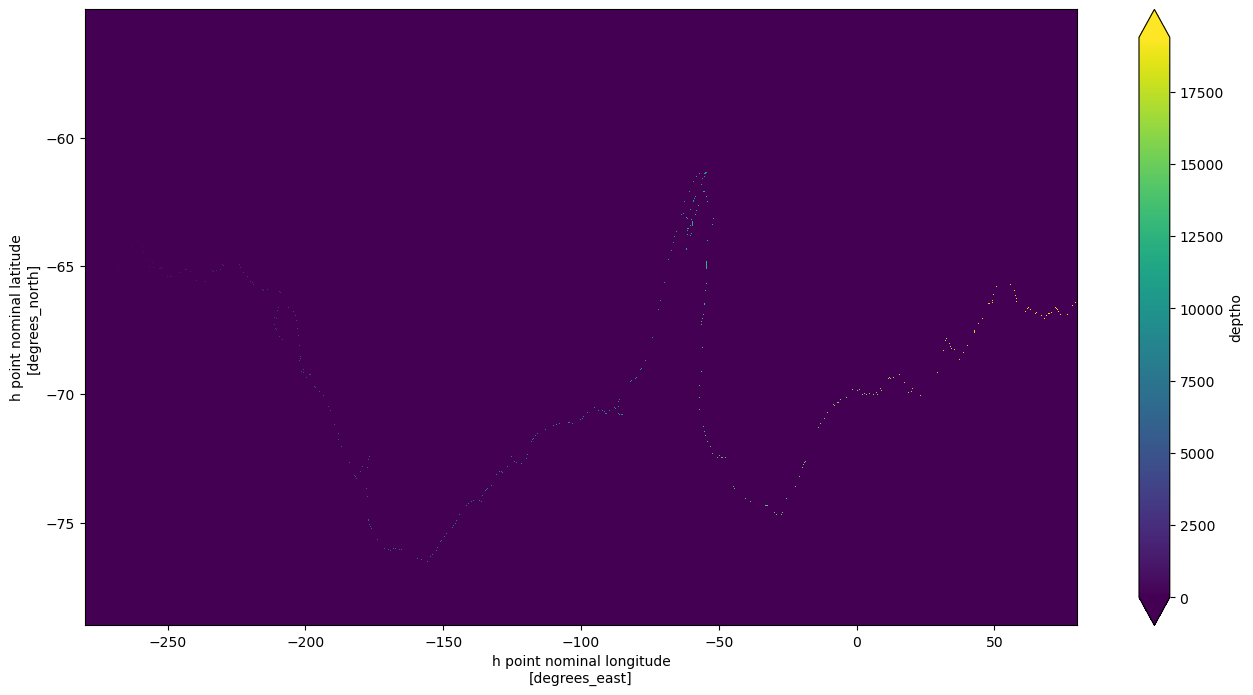

In [108]:
plt.figure(1, figsize=(16, 8))
contour_mask.plot(extend='both');

#### Extend mask when using the 3500 and 4000 m isobaths

These isobaths go through the northern boundary of the domain which makes it impossible to determine the direction of the contour as no comparison with one grid cell further north is possible. I therefore added two more rowsin the north so that the algorythm doesn't break but they will need to be cut off again in the end.

In [109]:
if contour_depth >= 3500:
    contour_mask_ext = contour_mask[:2, :]*0
    contour_mask_ext['yh'] = np.array([lat_range.stop+1, lat_range.stop+2])
    contour_mask = xr.concat((contour_mask, contour_mask_ext), dim='yh')

#### Create mask
Now we create a mask below contour so that the direction of the contour can be determined

**Remark on computational inefficiency**

Note that creating masks with nested `for` loops is very inefficient. We should probably use boolean masks (just compare the entire array with `mask_value`), and [`DataArray.shift()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.shift.html) or [`DataArray.roll()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.roll.html) from each of the directions to generate the masks without using loops.

See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179

In [110]:
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xh)-1):
    for jj in range(len(contour_mask.yh))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xh))[::-1][:-1]:
    for jj in range(len(contour_mask.yh))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xh))[::-1][:-1]:
    for jj in range(len(contour_mask.yh)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xh)-1):
    for jj in range(len(contour_mask.yh)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

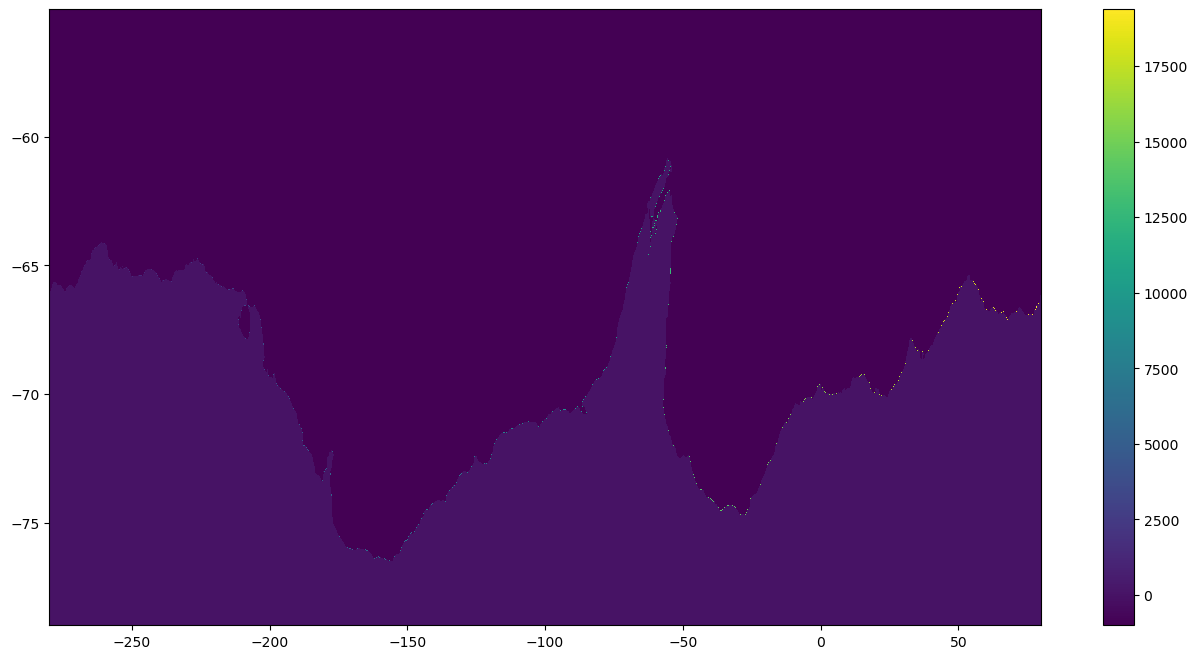

In [111]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(contour_mask[:-2, :].xh, contour_mask[:-2, :].yh, contour_masked_above[:-2, :])
plt.colorbar();

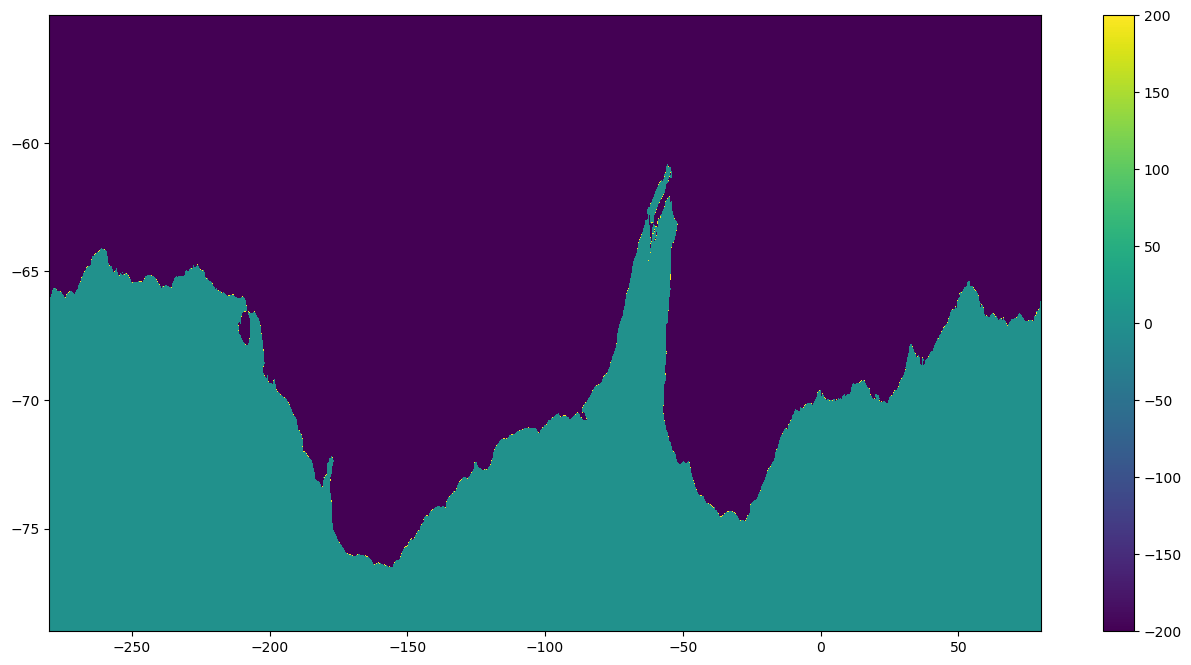

In [112]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(contour_mask[:-2, :].xh, contour_mask[:-2, :].yh, contour_masked_above[:-2, :], vmin=-200, vmax=200)
plt.colorbar();

South of the contour, values have been filled in to be -100, and it is thus a different colour in the plot.

#### Direction of cross-contour transport
Now we can use the mask south of the contour to determine whether the transport across the contour should be north, east, south or west (the grid is made of discrete square(ish) shaped cells). This is done by looping through the contour points and determining in which directions there are zeros (above contour) and -100 (below contour). This means the orientation of the contour can be determined. This is saved as `mask_x_transport`, which has -1 and +1 in a 2D (x and y) array where the contour has eastward transport, and `mask_y_transport` which as -1 and +1 for coordinates with northward transport. All other positions in the array are 0. This means that multiplying the northward transport `vmo` by the `mask_y_transport` gives all the northward transport across the contour, and zeros everywhere else (e.g. where contour goes upwards and cross-contour transport is thus eastward).

In [113]:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport[index_j, index_i] = -1        
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
    # if point to left and right BOTH toward Antarctica
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]==0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport[index_j, index_i] = -1        
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

#### Delete added rows in mask when using the 3500 and 4000 m isobaths

In [114]:
if contour_depth >= 3500:
    contour_mask = contour_mask[:-2, :]
    contour_mask_numbered = contour_mask_numbered[:-2, :]
    contour_masked_above = contour_masked_above[:-2, :]
    mask_x_transport = mask_x_transport[:-2, :]
    mask_x_transport_numbered = mask_x_transport_numbered[:-2, :]
    mask_y_transport = mask_y_transport[:-2, :]
    mask_y_transport_numbered = mask_y_transport_numbered[:-2, :]

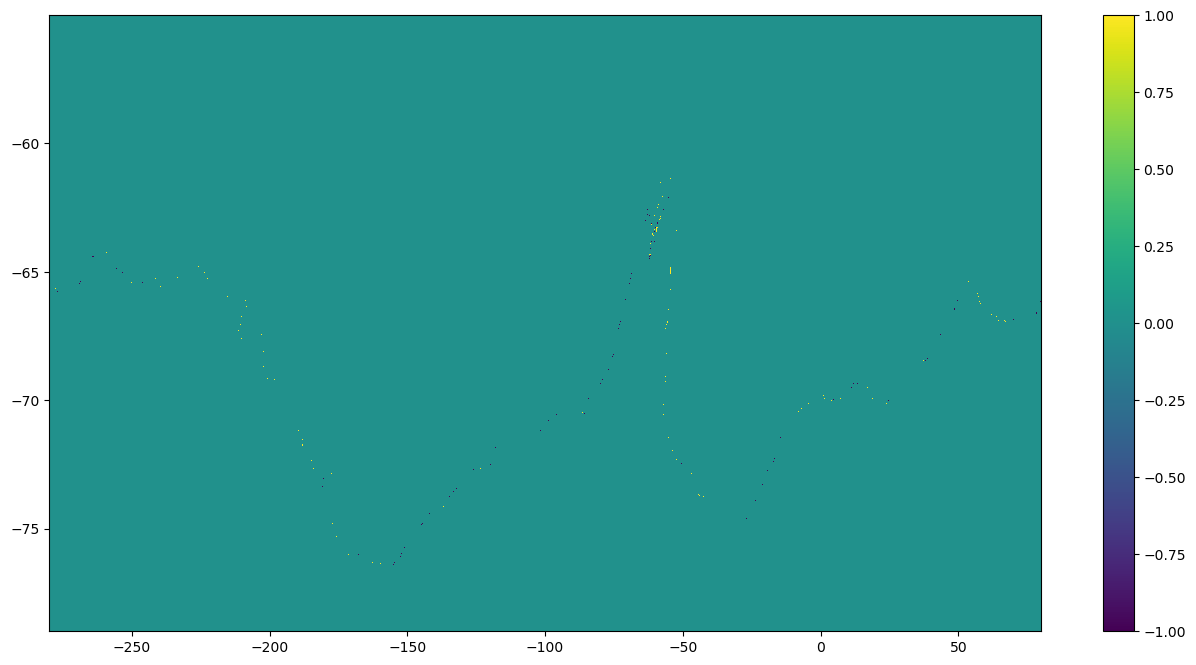

In [115]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(contour_mask.xh, contour_mask.yh, mask_x_transport)
plt.colorbar();

As can be seen, in `mask_x_transport` there is yellow (+1) where eastward transport crosses the contour, and (-1) where westward transport crosses the contour (in the net northward direction). There are zeros everywhere else.

### We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport. 

We now proceed to calculate transports across the contour

In [116]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vmo, so like vhrho this should have dimensions (yq, xh).
#       The x masks are used for umo, so like uhrho this should have dimensions (yh, xq).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yh, xq], dims = ['y_ocean','x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yq, xh], dims = ['y_ocean','x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yh, xq], dims = ['y_ocean','x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yq, xh], dims = ['y_ocean','x_ocean'])

And plot just to confirm that we didn't mess up anything.

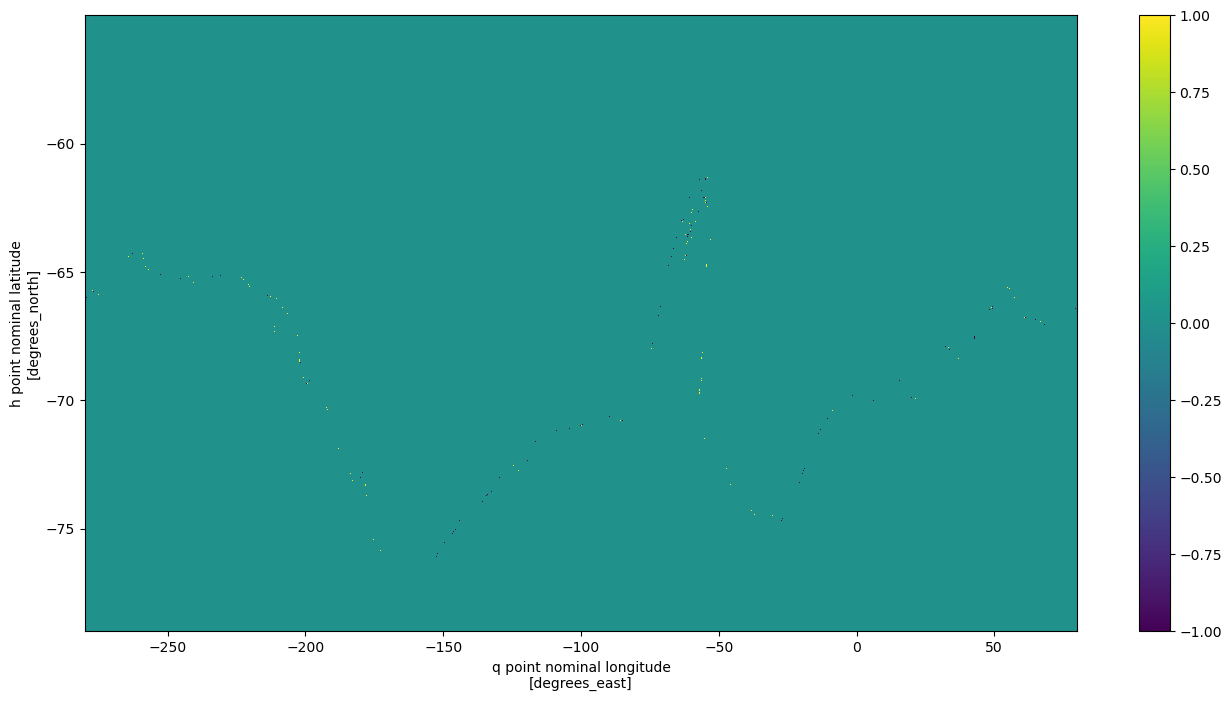

In [117]:
plt.figure(1, figsize=(16, 8))

mask_x_transport.plot(cmap="viridis");

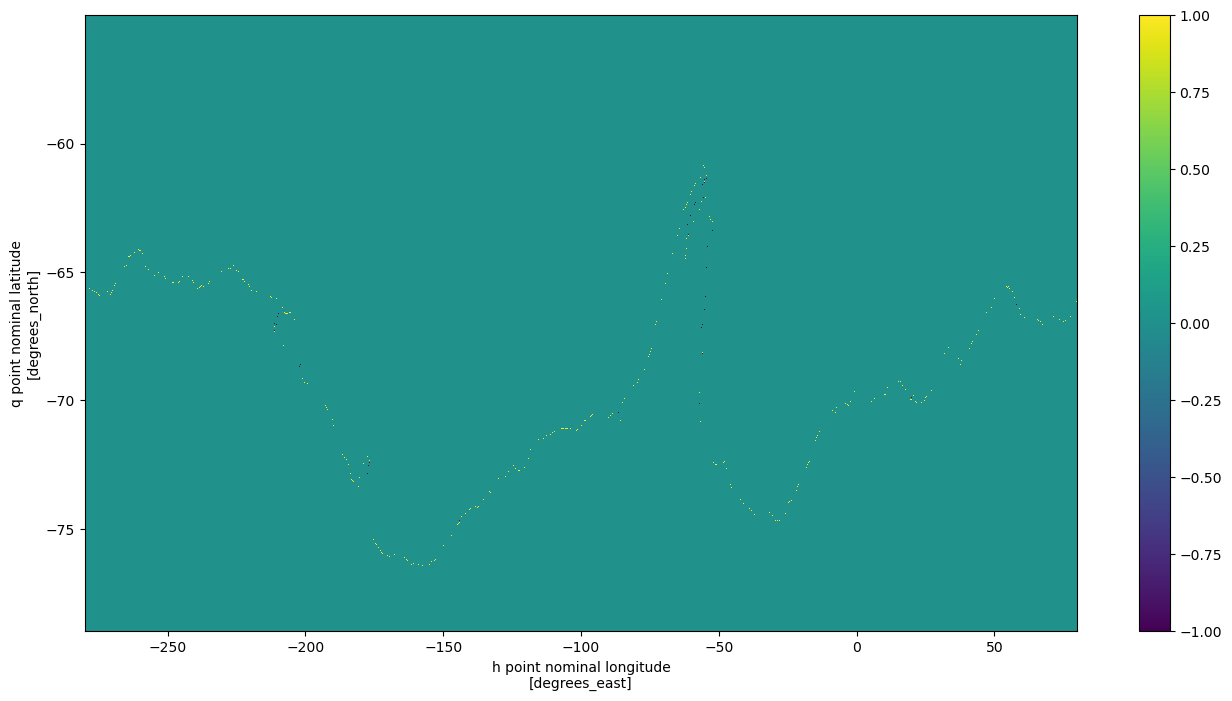

In [118]:
plt.figure(1, figsize=(16, 8))

mask_y_transport.plot(cmap="viridis");

#### Stack contour data into 1D

In [119]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [120]:
mask_x_transport.name = 'mask_x_transport'
ds = mask_x_transport.rename({'y_ocean': 'yh', 'x_ocean': 'xq'}).to_dataset()
ds['mask_y_transport'] = mask_y_transport.rename(
    {'y_ocean': 'yq', 'x_ocean': 'xh'})
ds['mask_x_transport_numbered'] = mask_x_transport_numbered.rename(
    {'y_ocean': 'yh', 'x_ocean': 'xq'})
ds['mask_y_transport_numbered'] = mask_y_transport_numbered.rename(
    {'y_ocean': 'yq', 'x_ocean': 'xh'})
ds['contour_masked_above'] = (['yh', 'xh'], contour_masked_above)
comp = dict(zlib=True, complevel=5, shuffle=True)
enc = {var: comp for var in ds.data_vars}
ds.to_netcdf(
    '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
    'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' + resolution +
    'deg.nc', encoding=enc)

In [121]:
ds

<xarray.Dataset>
Dimensions:                    (yh: 2132, xq: 14400, yq: 2132, xh: 14400)
Coordinates:
  * yh                         (yh) float64 -78.99 -78.98 ... -55.03 -55.02
  * xq                         (xq) float64 -280.0 -279.9 -279.9 ... 79.97 80.0
  * yq                         (yq) float64 -78.99 -78.98 ... -55.02 -55.01
  * xh                         (xh) float64 -280.0 -280.0 -279.9 ... 79.96 79.99
Data variables:
    mask_x_transport           (yh, xq) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mask_y_transport           (yq, xh) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mask_x_transport_numbered  (yh, xq) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mask_y_transport_numbered  (yq, xh) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    contour_masked_above       (yh, xh) float32 0.0 0.0 0.0 ... -1e+03 -1e+03

In [122]:
resolution

'0025'

In [123]:
contour_depth

650

#### Load transports `umo` and `vmo`

In [100]:
start_time = '1997-01-01'
end_time = '1997-12-31'
time_slice = slice(start_time, end_time)

vmo = cc.querying.getvar(experiment, 'vmo', session, frequency='1 monthly',
                         start_time = start_time, end_time = end_time)
vmo = vmo.sel(yq = lat_range, time = time_slice)

umo = cc.querying.getvar(experiment, 'umo', session,
                         start_time = start_time, end_time = end_time)
umo = umo.sel(yh = lat_range, time = time_slice)

vmo = vmo.rename({'yq': 'y_ocean', 'xh': 'x_ocean'})
umo = umo.rename({'yh': 'y_ocean', 'xq': 'x_ocean'})

#### Take time average

In [101]:
%%time
# weighed time mean by month length
days_in_month = umo.time.dt.days_in_month
days_in_year = 365

umo = (umo * days_in_month / days_in_year).sum('time')
umo = umo.load()

vmo = (vmo * days_in_month / days_in_year).sum('time')
vmo = vmo.load()

CPU times: user 25.8 s, sys: 3.99 s, total: 29.8 s
Wall time: 40.9 s


#### Convert from mass transport to volume transport

In [102]:
ρ0 = 1035 # kg/m^3

vmo = vmo * mask_y_transport / ρ0 # convert to Sv
umo = umo * mask_x_transport / ρ0 # convert to Sv

#### Extract transport values along contour

In [103]:
%%time
## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.

# stack transports into 1d and drop any points not on contour:
x_transport_1d = umo.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
y_transport_1d = vmo.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = vol_trans_across_contour.load()

CPU times: user 278 ms, sys: 6.06 ms, total: 284 ms
Wall time: 254 ms


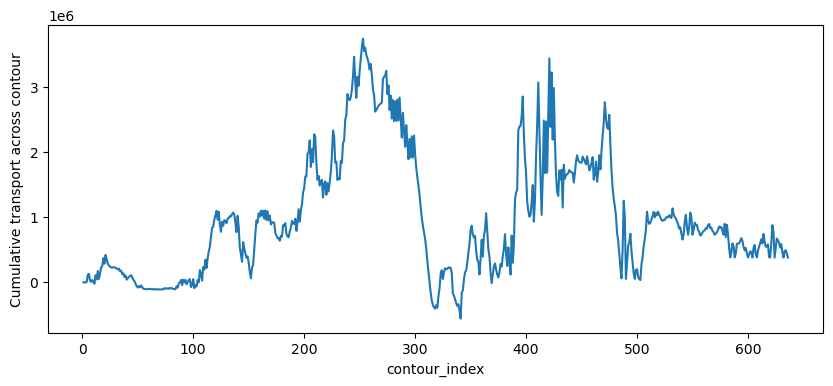

In [104]:
fig, ax = plt.subplots(figsize = (10, 4))

vol_trans_across_contour.sel(rho2_l=slice(1037.15, None)).sum(
    'rho2_l').cumsum('contour_index').plot()
ax.set_ylabel('Cumulative transport across contour');

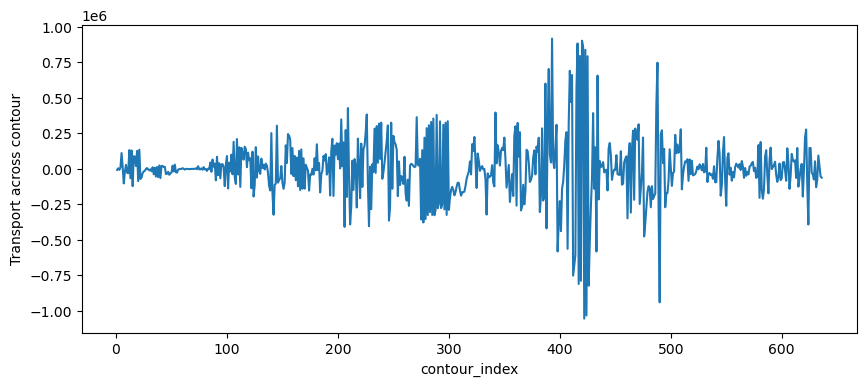

In [105]:
fig, ax = plt.subplots(figsize = (10, 4))

vol_trans_across_contour.sel(rho2_l=slice(1037.15, None)).sum(
    'rho2_l').plot()
ax.set_ylabel('Transport across contour');